In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
import re

In [3]:
raw_data_path = './data/raw/' # Path to raw data

## EU-MRV Emissions Analysis

EU-MRV is an EU regulation on the monitoring, reporting, and verification of carbon dioxide (CO₂) emissions from ships, which first entered into force on 1 July 2015. All ships of 5000 gross tonnage (GT) and above are required to report data regarding the emissions released during their voyages from and/or to ports in the European Economic Area. The monitoring plans used to make these reports need to be submitted to an accredited verifier. Full details of this arrangement can be seen in [the European Commission's FAQ](https://climate.ec.europa.eu/eu-action/transport/reducing-emissions-shipping-sector/faq-monitoring-reporting-and-verification-maritime-transport-emissions_en).

This notebook explores the yearly emissions data made available by the European Commission at https://mrv.emsa.europa.eu/#public/emission-report.

We focus on exploring the data in order to answer the following questions:

- How many ships of each type are there?
- How do the emissions profiles differ for the different ship types?
- What is the relationship between ship deadweight and emissions intensity?
- How many miles did each vessel in the database travel?

We also suggest some areas for further investigation.

### Data import and inspection

Is there anything about the data structure of these sheets that would prevent them from being used together?

Column headers are contained in the first three rows of each sheet. The first two rows serve as a way to categorise the columns, but since no third-level column headers are duplicated (and hence there's no ambiguity), it's sufficient to import the data using the third row as column headers.

Using the most recent available year (2022) as a reference, we check that the headers are consistent:

In [4]:
header_info = {}

for filename in os.listdir(raw_data_path):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(raw_data_path, filename)
        
        # Read the third row as the header
        header = pd.read_excel(file_path, header=None, skiprows=2, nrows=1).iloc[0]
        
        # Store header information
        header_info[filename] = header

c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\rich\miniconda3\envs\pydata-boo

In [5]:
# TODO: replace with a year-on-year comparison

reference_header = header_info['2022-v55-29082023-EU.xlsx']
# Dictionary to store differing columns for each file
differing_columns = {}

# Loop through the headers in header_info
for filename, header in header_info.items():
    # Skip the reference file
    if filename == '2022-v55-29082023-EU.xlsx':
        continue
    
    # Compare headers and find differing columns
    differing_cols = header[header != reference_header]
    
    differing_columns[filename] = differing_cols

In [6]:
differing_columns

{'2018-v269-16052023-EU.xlsx': 31    Annual Total time spent at sea [hours]
 45           Total time spent at sea [hours]
 Name: 0, dtype: object,
 '2019-v215-30062023-EU.xlsx': 31    Annual Total time spent at sea [hours]
 45           Total time spent at sea [hours]
 Name: 0, dtype: object,
 '2020-v191-20072023-EU.xlsx': Series([], Name: 0, dtype: object),
 '2021-v172-29082023-EU.xlsx': Series([], Name: 0, dtype: object)}

On inspection, we see that the `Annual Total time spent at sea [hours]` and `Total time spent at sea [hours]` columns were renamed to `Annual Time spent at sea [hours]` and `Time spent at sea [hours]` respectively between 2019 and 2020, but otherwise the column names have not changed.

We concatenate all sheets into a single DataFrame using the most recent year (2022) column names:

In [7]:
custom_column_headers =  header_info['2022-v55-29082023-EU.xlsx']

dataframes = []

# Loop through Excel files
for filename in os.listdir(raw_data_path):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(raw_data_path, filename)
        
        # Read the Excel file into a DataFrame with custom headers
        df = pd.read_excel(file_path, header=None, skiprows=3, names=custom_column_headers)
        
        # Append the DataFrame to the list
        dataframes.append(df)

# Concatenate DataFrames into a single DataFrame
mrv_df = pd.concat(dataframes, ignore_index=True)

c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


For convenience, we create a flattened dictionary of column names grouped by their category as defined in the first row of the sheet:

In [8]:
# Read only the header rows
header_df = pd.read_excel(os.path.join(raw_data_path, '2022-v55-29082023-EU.xlsx'), header=[0, 1, 2], nrows=0)

# Convert the header DataFrame to a dictionary
header_dict = header_df.columns.to_frame(index=False).to_dict()

# Create an empty dictionary to store column names grouped by headers
column_dict = {}

# Iterate through the grouped columns and their subcolumns
for group, subgroup, subcolumn in header_df.columns:
    dict_key = subgroup
    if subgroup.startswith('Unnamed'):
        dict_key = group
    if dict_key not in column_dict:
        column_dict[dict_key] = []
    column_dict[dict_key].append(subcolumn)

c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


We expect all columns in our `Totals`, `Average energy efficiency`, `Distance and time` and `Average energy efficiency on Laden Voyages` categories to be numeric, so we convert these (invalid parsing will be set as NaN):

In [9]:
numeric_columns = column_dict['Totals'] + column_dict['Average energy efficiency on Laden Voyages'] + column_dict['Distance and time'] + column_dict['Average energy efficiency']

for column_name in numeric_columns:
    mrv_df[column_name] = pd.to_numeric(mrv_df[column_name], errors='coerce')

In [10]:
mrv_df.head(5)

,IMO Number,Name,Ship type,Reporting Period,Technical efficiency,Port of Registry,Home Port,Ice Class,DoC issue date,DoC expiry date,...,Fuel consumption per transport work (pax) on laden voyages [g / pax · n miles],Fuel consumption per transport work (freight) on laden voyages [g / m tonnes · n miles],CO₂ emissions per distance on laden voyages [kg CO₂ / n mile],CO₂ emissions per transport work (mass) on laden voyages [g CO₂ / m tonnes · n miles],CO₂ emissions per transport work (volume) on laden voyages [g CO₂ / m³ · n miles],CO₂ emissions per transport work (dwt) on laden voyages [g CO₂ / dwt carried · n miles],CO₂ emissions per transport work (pax) on laden voyages [g CO₂ / pax · n miles],CO₂ emissions per transport work (freight) on laden voyages [g CO₂ / m tonnes · n miles],Additional information to facilitate the understanding of the reported average operational energy efficiency indicators,Average density of the cargo transported [m tonnes / m³]
0,5383304,ASTORIA,Passenger ship,2018,Not Applicable,NaN,NaN,NaN,05/02/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6417097,MARCO POLO,Passenger ship,2018,Not Applicable,NaN,NaN,IC,05/02/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6511128,RED STAR 1,Ro-pax ship,2018,EIV (45.57 gCO₂/t·nm),NaN,NaN,NaN,30/04/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6602898,OCEAN MAJESTY,Passenger ship,2018,EIV (31.73 gCO₂/t·nm),Madeira,NaN,NaN,06/05/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6703343,EQUALITY,Other ship types,2018,Not Applicable,Beirut,NaN,NaN,30/06/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
mrv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61860 entries, 0 to 61859
Data columns (total 61 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   IMO Number                                                                                                               61860 non-null  int64  
 1   Name                                                                                                                     61860 non-null  object 
 2   Ship type                                                                                                                61860 non-null  object 
 3   Reporting Period                                                                                                         61860 non-null 

According to the EU Maritime MRV Regulation, ships have to report their technical efficiency.
This can be done through two indicators, which are mutually exclusive and apply depending
on the year of build of the ship: the Energy Efficiency Design Index (EEDI) or the Estimated
Index Value (EIV). A third possibility is to report the entry ‘not applicable’, an exemption
for a minority of ship types not covered by the MARPOL Annex VI Regulations. 

According to the [MRV monitoring plans](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=celex:32016R1927#ntr12-L_2016299EN.01000401-E0012), the `Technical efficiency` column should contain one of the following:

- Energy Efficiency Design Index (*EEDI*), where required by MARPOL, Annex VI, Chapter 4, Regulations 19 and 20, expressed in grams CO2/tonne-nautical mile

- Estimated Index Value (*EIV*), calculated in accordance with IMO Resolution MEPC.215 (63), expressed in grams CO2/tonne-nautical mile

- '_Not Applicable_' otherwise

In order to make use of this column in downstream analysis, we do the following:

- create a `Technical efficiency method` categorical column holding the method used (EEDI or EIV)
- convert the `Technical efficiency` column to numeric

In [12]:
# Function for extracting the technical efficiency method
def extract_technical_method(text):
    match = re.match(r'^(EIV|EEDI)', text)
    if match:
        return match.group()
    else:
        return 'NA'

# Function for extracting the numerical value from technical efficiency
def extract_numerical_value(text):
    match = re.search(r'\((\d+\.\d+) g', text)
    if match:
        return float(match.group(1))
    else:
        return np.nan

In [13]:
# Add column 'Technical efficiency method'
mrv_df['Technical efficiency method'] = mrv_df['Technical efficiency'].astype(str).apply(extract_technical_method)

In [14]:
# Convert the 'Technical efficiency' column numerical value where available
mrv_df['Technical efficiency'] = mrv_df['Technical efficiency'].astype(str).apply(extract_numerical_value)

### How many ships of each type are there?

We count the number of ships of each type registered in each year.

In [15]:
# Check the distinct values which appear in the 'Ship type' column
distinct_ship_values = sorted(mrv_df['Ship type'].unique(), reverse=False)
distinct_ship_values

['Bulk carrier',
 'Chemical tanker',
 'Combination carrier',
 'Container ship',
 'Container/ro-ro cargo ship',
 'Gas carrier',
 'General cargo ship',
 'LNG carrier',
 'Oil tanker',
 'Other ship types',
 'Passenger ship',
 'Refrigerated cargo carrier',
 'Ro-pax ship',
 'Ro-ro ship',
 'Vehicle carrier']

These are consistent with the ship categories specified in Annex III of the [templates for monitoring plans, emissions reports and documents of compliance](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=celex:32016R1927#ntr12-L_2016299EN.01000401-E0012). 

We see that all ship types appear in the data.

In [16]:
# Count the number of ships of each type registered in each year
ship_count_df = mrv_df.pivot_table(index='Reporting Period', columns='Ship type', aggfunc='size', fill_value=0)

# Show the transpose of the counts (i.e. reporting years as columns)
ship_count_df.T

Reporting Period,2018,2019,2020,2021,2022
Ship type,,,,,
Bulk carrier,3845,3666,3479,3755,4006
Chemical tanker,1364,1362,1352,1393,1413
Combination carrier,10,11,15,6,9
Container ship,1813,1851,1857,1833,1828
Container/ro-ro cargo ship,80,76,70,64,60
Gas carrier,321,343,345,328,353
General cargo ship,1177,1245,1244,1259,1173
LNG carrier,213,257,278,300,387
Oil tanker,1907,2007,1936,1851,1975


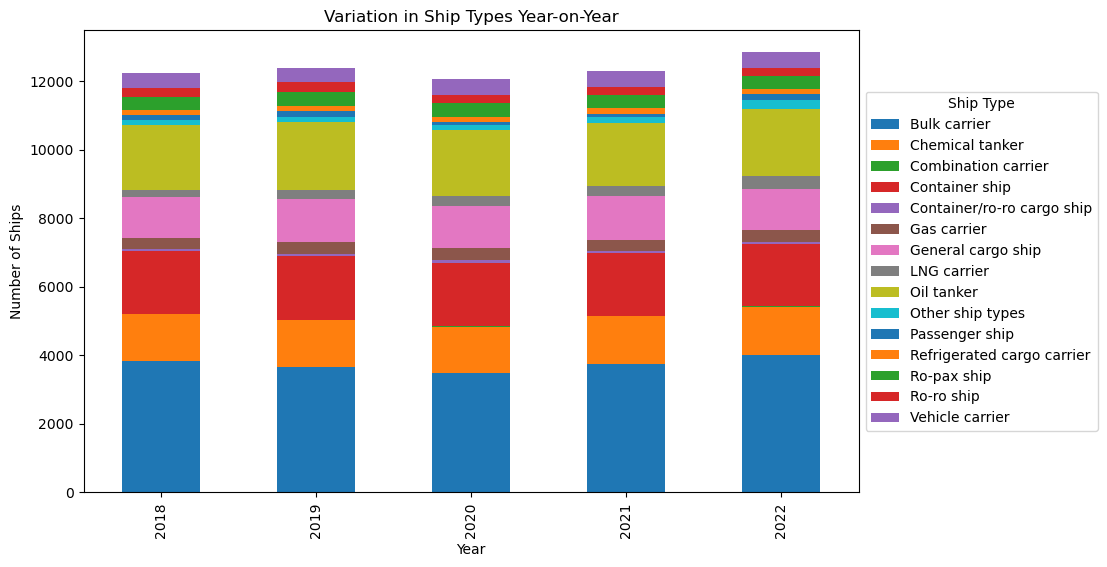

In [17]:
# Create a stacked bar chart
ax = ship_count_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Variation in Ship Types Year-on-Year')
plt.xlabel('Year')
plt.ylabel('Number of Ships')
ax.legend(title='Ship Type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We see that in all reporting years, `Bulk carrier`, `Oil tanker`, `Ro-ro ship`, `Refriderated cargo carrier` and `General cargo ship` make up the majority of the reported fleet.

The year-on-year changes in ship type are easier to grasp if we visualise them as a grouped bar plot:

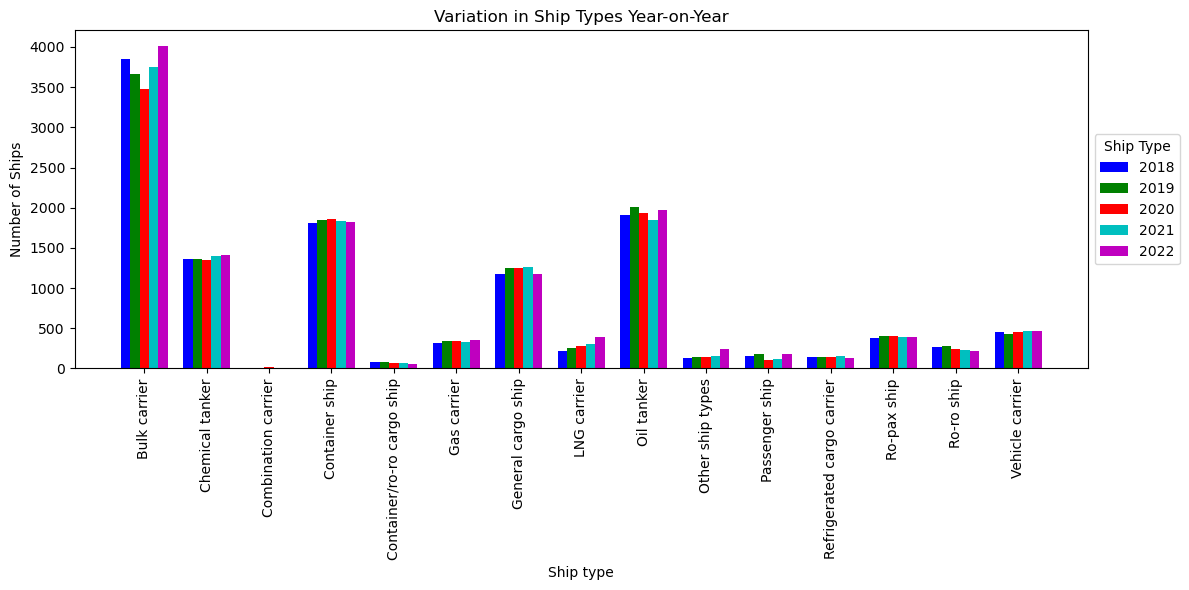

In [18]:
# Transpose the count table to make plotting easier
ship_count_df_transposed = ship_count_df.T

# Set the figure size
plt.figure(figsize=(12, 6))

# Define the colors for each ship type
colors = ['b', 'g', 'r', 'c', 'm']

# Create a grouped bar chart
bar_width = 0.15  # Width of each bar
index = np.arange(len(ship_count_df_transposed.index))  # X-axis index values

for i, ship_type in enumerate(ship_count_df_transposed.columns):
    plt.bar(
        index + i * bar_width,  # X-axis positions for each group
        ship_count_df_transposed[ship_type],  # Y-axis values for each group
        bar_width,
        label=ship_type,
        color=colors[i]
    )

plt.xlabel('Ship type')
plt.ylabel('Number of Ships')
plt.title('Variation in Ship Types Year-on-Year')
plt.xticks(
    index + (bar_width * (len(ship_count_df_transposed.columns) - 1) / 2), 
    ship_count_df_transposed.index, 
    rotation=90
)
plt.legend(title='Ship Type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


As well as an understandable dip in the number of `Passenger ship` reporting during 2020-2021 pandemic years (and subsequent recovery), we see other interesting trends, like a steady increase in the number of reporting `LNG carrier` (liquid natural gas carrier).

### How do the emissions profiles differ for the different ship types?

In [19]:
def calculate_percentiles_and_counts(series, percentiles):
    '''Takes a series and a set of percentiles, returns a dictionary containing percentiles as key and counts above percentile as values'''

    result = {}
    
    for percentile in percentiles:
        percentile_value = series.quantile(percentile)
        count_above_percentile = (series > percentile_value).sum()
        result[f'{percentile*100:.0f}th Percentile'] = {
            'Value': percentile_value,
            'Count Above': count_above_percentile
        }
    
    return result

According to the [templates for monitoring plans](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=celex:32016R1927#ntr12-L_2016299EN.01000401-E0012), different measures of transport work are applicable to different types of ship:

- passenger-nautical miles (for passenger ships)
- tonne-nautical miles (for ro-ro ships, container ships, oil tankers, chemical tankers, gas carriers, bulk carriers, refrigerated cargo carriers, vehicle carriers, combination carriers)
- cubic meter-nautical miles, (for LNG carriers, container/ro-ro cargo ships)
- deadweight-tonne carried-nautical miles (for general cargo ships)
- passenger-nautical miles AND tonne-nautical miles (for ro-pax ships)
- tonne-nautical miles OR deadweight-tonne carried-nautical miles (for other ship types)

We therefore use the reported `Technical efficiency` as a measure of emissions intensity, as this allows for a like-for-like comparison.

In [20]:
mrv_df['Technical efficiency'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

count    55393.000000
mean        10.568114
std         13.535391
min          0.010000
25%          4.420000
50%          6.930000
75%         13.900000
90%         21.070000
95%         26.550000
99%         41.610000
max        972.160000
Name: Technical efficiency, dtype: float64

In [21]:
# Count the values above high percentiles in technical efficiency 
calculate_percentiles_and_counts(
    mrv_df['Technical efficiency'], 
    [.9, .95, .99, .995]
)

{'90th Percentile': {'Value': 21.07, 'Count Above': 5537},
 '95th Percentile': {'Value': 26.55, 'Count Above': 2764},
 '99th Percentile': {'Value': 41.61, 'Count Above': 552},
 '100th Percentile': {'Value': 52.17, 'Count Above': 274}}

We see that 75% of the values fall between about 4.4 and 19.3 gCO₂/t·nm, with the mean pulled up significantly above the median by outliers.

For the purpose of inspecting distributions visually, we create a filtered version of the dataset with only technical efficiencies below the 99.5 percentile.

In [22]:
# Calculate the 99.5th percentile of annual average CO₂ emissions per transport work
percentile_995 = mrv_df['Technical efficiency'].quantile(0.995)

# Filter data to exclude values above the 99.5th percentile
filtered_df = mrv_df[mrv_df['Technical efficiency'] <= percentile_995]

In [23]:
filtered_df['Technical efficiency'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

count    55119.000000
mean        10.066007
std          7.810255
min          0.010000
25%          4.410000
50%          6.900000
75%         13.780000
90%         20.690000
95%         25.880000
99%         37.530000
max         52.170000
Name: Technical efficiency, dtype: float64

What does the distribution of technical efficiency look like in each year?

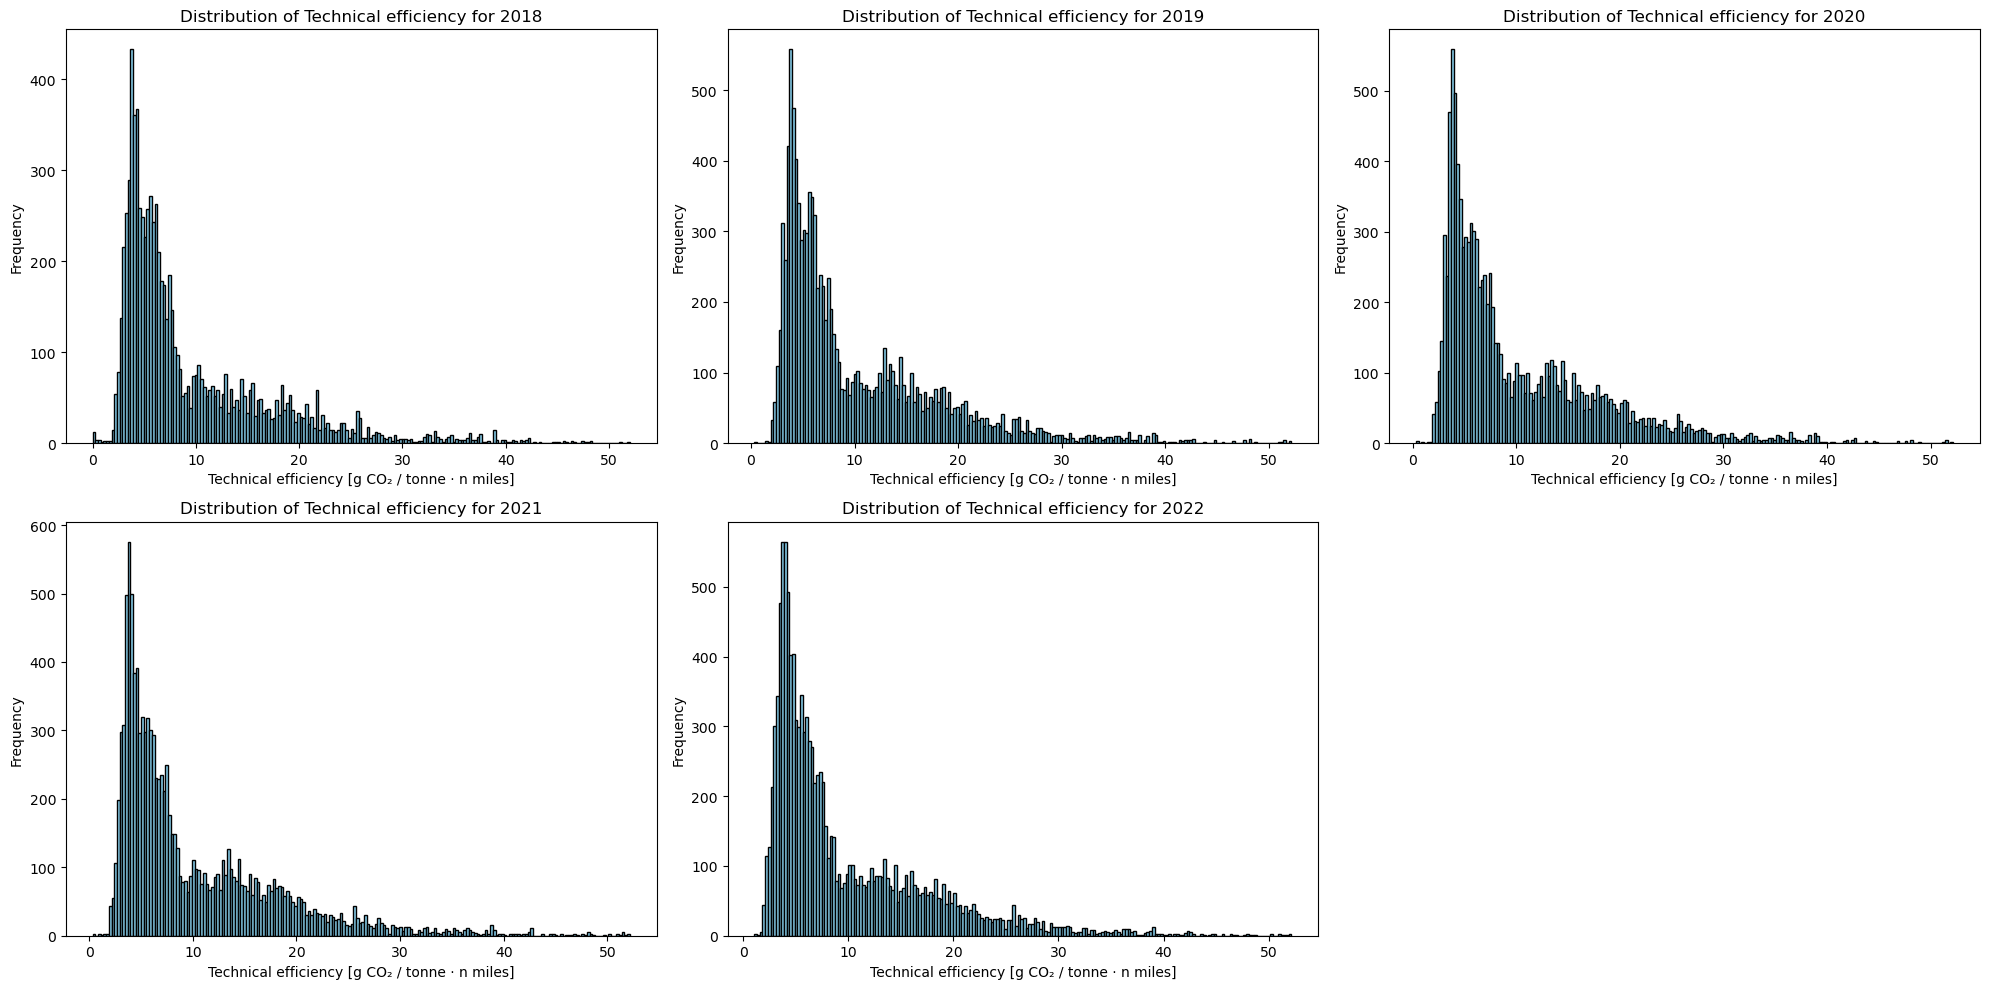

In [24]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Loop through each year and create a histogram subplot
years = filtered_df['Reporting Period'].unique()
for i, year in enumerate(years):
    ax = axes.flat[i]
    ax.hist(filtered_df[filtered_df['Reporting Period'] == year]['Technical efficiency'], bins=200, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of Technical efficiency for {year}')
    ax.set_xlabel('Technical efficiency [g CO₂ / tonne · n miles]')
    ax.set_ylabel('Frequency')

# Hide unused subplots
for i in range(len(years), len(axes.flat)):
    axes.flat[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

How does technical efficiency vary by ship type? We consider records from the most recent reporting year, 2022.

In the original joined dataset, there's a significant class imbalance between the ship types for which the `Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]` column is reported. We see that some ship types only appear once, and that the majority of responses are for `General cargo ship`:

In [25]:
# Group by 'Ship type' and calculate summary statistics for 2022, order by median 
(
    filtered_df[filtered_df['Reporting Period'] == 2022]
    .groupby('Ship type')['Technical efficiency']
    .describe()
    .sort_values(by='50%', ascending=False)
)

,count,mean,std,min,25%,50%,75%,max
Ship type,,,,,,,,
Ro-pax ship,309.0,24.399029,12.143749,1.07,18.0800,23.900,32.3600,52.17
Refrigerated cargo carrier,126.0,21.190079,5.473359,8.27,16.5075,21.360,25.6100,38.89
Vehicle carrier,449.0,19.053586,5.730422,5.30,15.7200,17.570,21.4900,48.54
Container ship,1726.0,17.845875,7.900426,3.93,11.5950,17.530,22.0100,47.68
Passenger ship,155.0,15.247226,8.104160,2.18,9.1650,15.030,19.3100,41.98
Other ship types,151.0,16.922450,8.993039,2.88,10.0800,14.820,22.6600,42.41
Ro-ro ship,211.0,16.086493,8.674116,4.10,10.4900,13.500,19.7400,51.54
General cargo ship,1115.0,12.218018,5.774924,3.11,7.5400,12.410,14.5500,44.60
Gas carrier,338.0,11.851982,5.953253,1.62,7.2675,10.220,16.1150,41.98


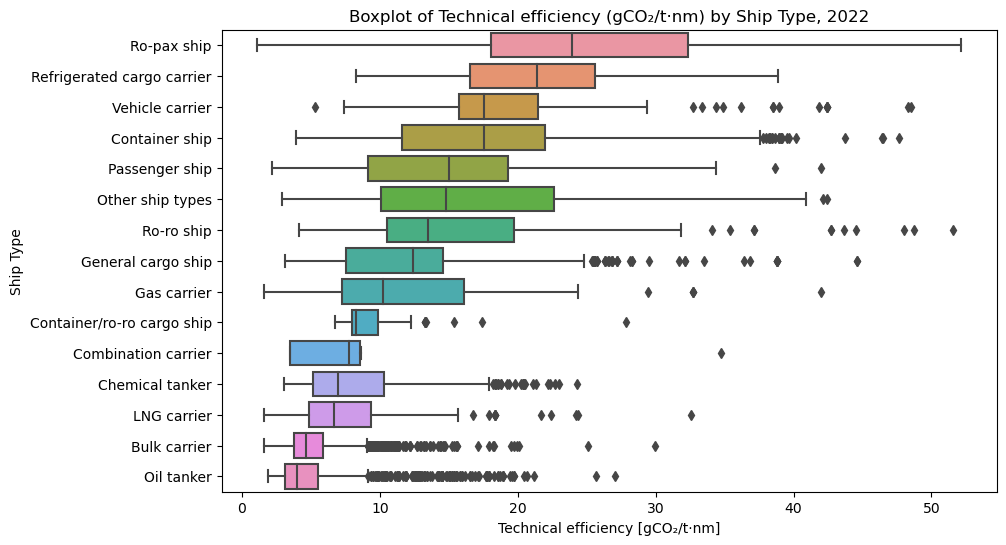

In [26]:
# Create a boxplot of technical efficiency by ship type for year 2022

# Calculate the median of technical efficiency for each ship type for ordering the plot
median_order = (
    filtered_df[filtered_df['Reporting Period'] == 2022]
    .groupby('Ship type')['Technical efficiency']
    .median()
    .sort_values(ascending=False).index
)

plt.figure(figsize=(10, 6)) 
sns.boxplot(data=filtered_df[filtered_df['Reporting Period'] == 2022], y='Ship type', x='Technical efficiency', order=median_order)

plt.title('Boxplot of Technical efficiency (gCO₂/t·nm) by Ship Type, 2022')
plt.xlabel('Technical efficiency [gCO₂/t·nm]')
plt.ylabel('Ship Type')
plt.show()

We see that `Ro-pax ship`, `Refrigerated cargo carrier` and `vehicle carrier` generally have higher reported technical efficiencies, while `Oil tanker`, `Bulk carrier` and `LNG carrier` (liquid natural gas carrier) generally have lower. 

Note that as the median technical efficiency of a class increases, so does the spread of efficiencies in that class.

The dataset also contains measurements of CO₂ emissions broken down by the juristiction of the original and destination port, as well as those at berth (in port).

How does the share of total emissions made while

- at berth
- incoming to EEA members
- outgoing from EEA members
- moving between EEA members

vary by ship type?

Note: this calculation will produce NaN values where either the numerator or denominator is zero, and so these rows will be excluded from the means.

In [27]:
emission_proportions = mrv_df[[
    'Ship type',
    'CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]',
    'CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]',
    'CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]',
    'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]'
]].copy()

# Recalcuate total emmissions using the above columns
emission_proportions['Total CO₂ emissions [m tonnes]'] = (
    emission_proportions['CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]'] +
    emission_proportions['CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]'] +
    emission_proportions['CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]'] +
    emission_proportions['CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]']
)

# Calculate proportion columns
emission_proportions['at berth'] = (
    emission_proportions['CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]'] 
    / emission_proportions['Total CO₂ emissions [m tonnes]']
)
emission_proportions['between EEA'] = (
    emission_proportions['CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]'] 
    / emission_proportions['Total CO₂ emissions [m tonnes]']
)
emission_proportions['from EEA'] = (
    emission_proportions['CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]'] 
    / emission_proportions['Total CO₂ emissions [m tonnes]']
)
emission_proportions['to EEA'] = (
    emission_proportions['CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]'] 
    / emission_proportions['Total CO₂ emissions [m tonnes]']
)

emission_proportions.drop(
    [
        'Total CO₂ emissions [m tonnes]',
        'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]',
        'CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]',
        'CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]',
        'CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]'
    ], 
    axis=1, 
    inplace=True)

emission_proportion_means = emission_proportions.groupby('Ship type').mean()

In [28]:
emission_proportion_means

,at berth,between EEA,from EEA,to EEA
Ship type,,,,
Bulk carrier,0.050057,0.087944,0.386737,0.475261
Chemical tanker,0.098580,0.240700,0.302568,0.358152
Combination carrier,0.060211,0.144171,0.391325,0.404292
Container ship,0.048914,0.259063,0.341561,0.350462
Container/ro-ro cargo ship,0.071845,0.350134,0.252345,0.325676
Gas carrier,0.078953,0.176592,0.373648,0.370807
General cargo ship,0.051718,0.248875,0.342849,0.356559
LNG carrier,0.034779,0.044687,0.449353,0.471181
Oil tanker,0.103348,0.122455,0.366584,0.407613


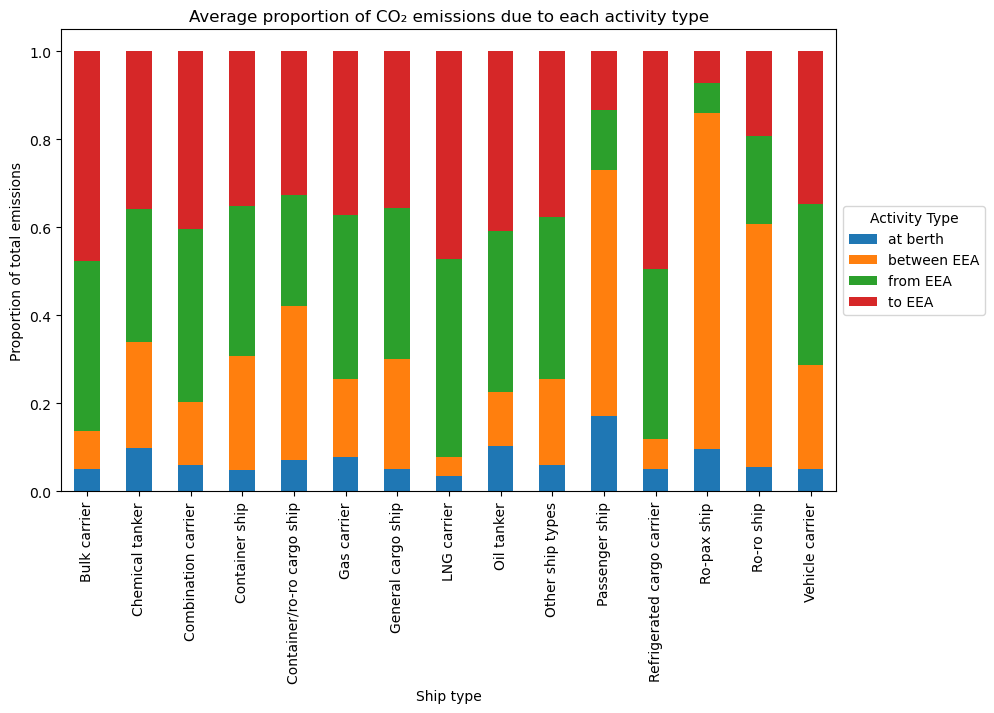

In [29]:
# Create a stacked bar chart showing proportion of emissions for each activity
ax = emission_proportion_means.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Average proportion of CO₂ emissions due to each activity type')
plt.xlabel('Ship type')
plt.ylabel('Proportion of total emissions')
ax.legend(title='Activity Type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

`Passenger ship`, `Ro-pax ship` and `Ro-ro ship` all stand out as having the majority of their emissions attributed to between-EEA voyages. This probably just reflects that the general activity of this ship type in the recorded fleet performs duties such as ferry services carrying passengers and roll-on roll-off cargo between EU member states.

We also focus on the proportion of emissions made while at berth:

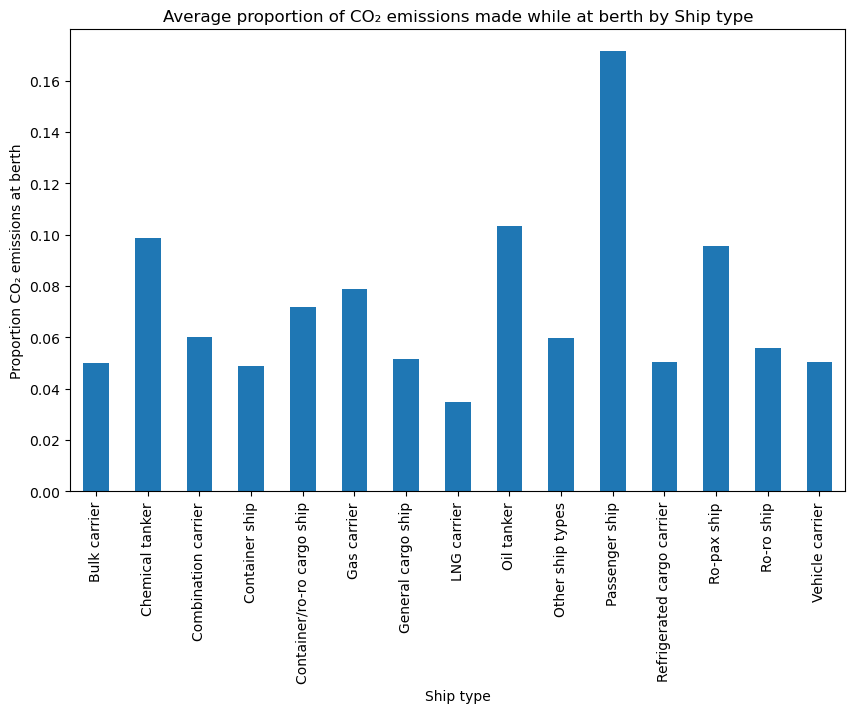

In [30]:
# Bar plot of mean proportion of emissions made at berth, per ship type
at_berth_proportions = emission_proportion_means['at berth']
ax = at_berth_proportions.plot(kind='bar', y='Proportion CO₂ emissions at berth', legend=False, figsize=(10, 6))
plt.title('Average proportion of CO₂ emissions made while at berth by Ship type')
plt.xlabel('Ship type')
plt.ylabel('Proportion CO₂ emissions at berth')
plt.show()

We see that `Passenger ship` stands out with fraction of emissions made at berth about twice of that of other ship categories. This might be for the following reasons:

- Compared to cargo ships, passenger ships might spend extended periods with engines idling, such as in busy ports. During this time, the ship's engines might continue to run for various reasons like maintaining onboard facilities, powering essential systems, and providing passenger comfort.

- Compared to cargo ships, passenger ships might offer a range of onboard services to enhance the passenger experience, such as air conditioning, lighting, entertainment systems, and other amenities. These services require continuous power, leading to higher energy consumption and emissions while the ship is at berth.

Which ship types show the greatest and smallest year-on-year improvement in emissions per nautical mile?

In [31]:
# Group by 'Ship type' and calculate summary statistics for emissions per distance
mrv_df.groupby('Ship type')['Annual average CO₂ emissions per distance [kg CO₂ / n mile]'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Ship type,,,,,,,,,,,
Bulk carrier,17571.0,334.555543,2404.538033,0.00,240.0600,284.580,334.6150,422.100,496.3500,604.5840,202022.51
Chemical tanker,6790.0,310.024476,2596.095052,35.09,219.3050,270.875,322.6050,375.468,407.9670,536.5531,214013.12
Combination carrier,51.0,319.243725,128.005351,108.38,246.8350,316.960,364.9050,455.150,464.2500,725.6450,887.03
Container ship,8992.0,633.678645,4140.293018,0.00,323.6650,552.145,827.9550,981.426,1057.7625,1203.3794,392246.37
Container/ro-ro cargo ship,350.0,399.723429,118.339408,104.81,322.2175,399.865,450.1900,534.445,565.2270,685.3783,1325.58
Gas carrier,1674.0,319.216780,230.585248,55.69,223.8375,277.185,367.5500,430.330,547.7180,1170.6651,4997.04
General cargo ship,5985.0,199.617250,126.002038,8.93,140.1500,182.750,247.2400,301.908,329.1860,401.7488,7946.75
LNG carrier,1428.0,833.878438,294.911604,82.24,619.8000,799.000,1024.2625,1192.304,1305.9780,1786.8433,2521.34
Oil tanker,9501.0,693.460049,23656.146573,57.58,324.0000,420.810,523.6700,635.910,729.9800,1014.4200,2305780.00


In [32]:
# Count the values above high percentiles in Annual average CO₂ emissions per distance
calculate_percentiles_and_counts(
    mrv_df['Annual average CO₂ emissions per distance [kg CO₂ / n mile]'], 
    [.9, .95, .99, .9995]
)

{'90th Percentile': {'Value': 694.07, 'Count Above': 5996},
 '95th Percentile': {'Value': 887.5284999999997, 'Count Above': 2999},
 '99th Percentile': {'Value': 1182.8831, 'Count Above': 600},
 '100th Percentile': {'Value': 4678.900690000002, 'Count Above': 30}}

We see a small number of 30 ships whose calculated average emissions per unit distance are several orders of magnitude higher that the rest of the recorded fleet.

Since we don't have access to raw annual distances for each vessel, we can't try to reproduce using the `Total CO₂ emissions [m tonnes]` column. These high values are worth investigating further, but for the purpose of our analysis, we exclude these ships from our year on year comparison. 

In [33]:
# Filter the DataFrame to exclude rows above a given emissions per distance threshold

percentile_threshold = .9995
threshold_value = mrv_df['Annual average CO₂ emissions per distance [kg CO₂ / n mile]'].quantile(percentile_threshold)

emissions_df = mrv_df[['Ship type', 'Reporting Period', 'Annual average CO₂ emissions per distance [kg CO₂ / n mile]']].copy()
emissions_df = emissions_df[emissions_df['Annual average CO₂ emissions per distance [kg CO₂ / n mile]'] <= threshold_value]

# Create a table to display the yearly averages
emissions_table = pd.pivot_table(emissions_df, values='Annual average CO₂ emissions per distance [kg CO₂ / n mile]', index='Ship type', columns='Reporting Period', aggfunc='mean')

In [34]:
# Create a styled version of table of yearly average values to make is easier to spot anomalous values

# Define a color map (colormap)
cmap = sns.diverging_palette(220, 20, as_cmap=True) 

# Apply color highlighting to the table
styled_emissions_table = emissions_table.style.background_gradient(cmap=cmap, axis=None, vmin=None, vmax=None)

styled_emissions_table

Reporting Period,2018,2019,2020,2021,2022
Ship type,,,,,
Bulk carrier,309.757288,306.874719,287.644337,302.576332,302.645888
Chemical tanker,289.990015,285.148241,274.032850,267.544916,273.330434
Combination carrier,357.106000,318.777273,336.502000,248.428333,296.191111
Container ship,596.424853,579.861488,582.053819,606.160188,584.095826
Container/ro-ro cargo ship,412.149625,391.540000,389.443286,398.538125,406.778667
Gas carrier,325.300680,324.530616,321.255481,296.685749,314.396969
General cargo ship,202.268952,199.456534,191.651480,195.731405,203.076848
LNG carrier,923.429856,894.884125,853.877473,770.962215,779.135788
Oil tanker,457.667172,454.698811,446.171220,422.671864,429.534995


In [35]:
# Create a table of year-on-year percentage changes in emissions
percentage_change_table = (
    emissions_table
    .pct_change(axis=1)
    .drop(columns=2018) * 100
)

# Apply color highlighting to the table
styled_percentage_change_table = percentage_change_table.style.background_gradient(cmap=cmap, axis=None, vmin=None, vmax=None)

styled_percentage_change_table

Reporting Period,2019,2020,2021,2022
Ship type,,,,
Bulk carrier,-0.930590,-6.266525,5.191131,0.022988
Chemical tanker,-1.669635,-3.898110,-2.367575,2.162447
Combination carrier,-10.733151,5.560223,-26.173297,19.225978
Container ship,-2.777109,0.378078,4.141605,-3.640022
Container/ro-ro cargo ship,-5.000520,-0.535504,2.335344,2.067692
Gas carrier,-0.236724,-1.009191,-7.648035,5.969690
General cargo ship,-1.390435,-3.913160,2.128825,3.752818
LNG carrier,-3.091272,-4.582342,-9.710440,1.060178
Oil tanker,-0.648585,-1.875437,-5.266892,1.623749


We see a large percentage change between 2019 and 2020 for passenger ships of about 47% for passenger ships, which might be explained by the COVID-19 pandemic's impact on the routes, schedules and modes of operation of passenger travel. Disruption may have made operations less efficient.

In [36]:
# Produce a ranking of the 2021-2022 percentage changes
percentage_change_table[2022].sort_values(ascending=False)

Ship type
Combination carrier           19.225978
Gas carrier                    5.969690
Vehicle carrier                4.045118
General cargo ship             3.752818
Chemical tanker                2.162447
Container/ro-ro cargo ship     2.067692
Oil tanker                     1.623749
LNG carrier                    1.060178
Bulk carrier                   0.022988
Ro-pax ship                   -1.379579
Ro-ro ship                    -1.531503
Container ship                -3.640022
Other ship types              -4.612666
Refrigerated cargo carrier    -5.711594
Passenger ship               -14.224832
Name: 2022, dtype: float64

Focusing on the 2021-2022 percentage change, we see that `Combination carrier`, `Gas carrier` and `Vehicle carrier` experienced the largest increases, while `Passenger ship`, `Refrigerated cargo carrier` and `Other ship types` experienced the largest decreases.

### How many nautical miles did each vessel in the database travel?

We can estimate the distance that each ship travelled in a year by using the `Total fuel consumption [m tonnes]` and `Annual average Fuel consumption per distance [kg / n mile]` columns:

$$
\scriptsize
\text{annual distance estimate} = \frac{\text{total fuel consumption}}{\text{annual average fuel consumption per distance}}
$$

In [37]:
# Create a new column for `Annual distance estimate [n mile]`
mrv_df['Annual distance estimate [n mile]'] = round(mrv_df['Total fuel consumption [m tonnes]'] * 1000 / mrv_df['Annual average Fuel consumption per distance [kg / n mile]'], 2)

We aren't able to make this calculation for 1890 rows where we were missing average Fuel consumption per distance information:

In [38]:
mrv_df['Annual distance estimate [n mile]'].isna().sum()

1890

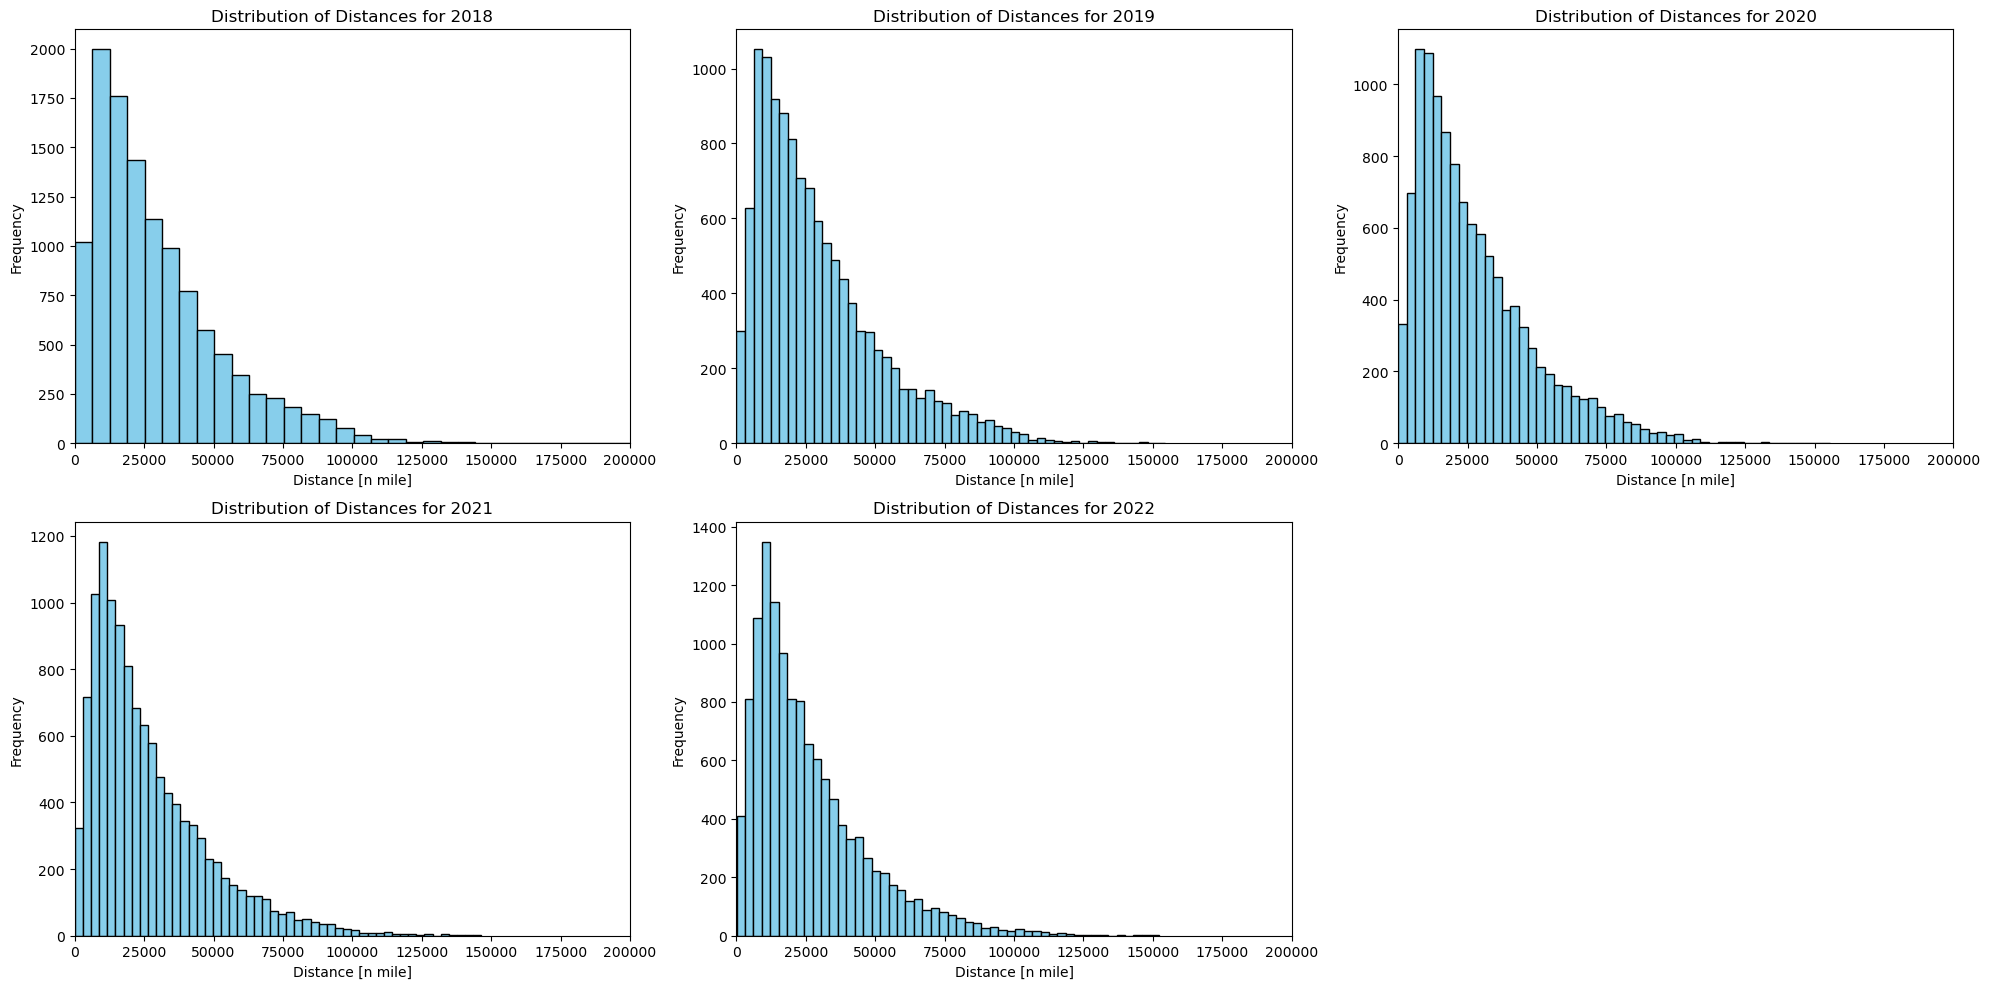

In [39]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Loop through each year and create a histogram subplot
years = mrv_df['Reporting Period'].unique()
for i, year in enumerate(years):
    ax = axes.flat[i]
    ax.hist(mrv_df[mrv_df['Reporting Period'] == year]['Annual distance estimate [n mile]'], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of Distances for {year}')
    ax.set_xlabel('Distance [n mile]')
    ax.set_ylabel('Frequency')

# Hide unused subplots
for i in range(len(years), len(axes.flat)):
    axes.flat[i].axis('off')

# Set the upper x-axis limit for all subplots to 200000 n miles for easier visual comparison
for ax in axes.flat:
    ax.set_xlim(0, 200000)

# Adjust layout
plt.tight_layout()
plt.show()

How does the distribution of these distance estimates vary depending on ship type?

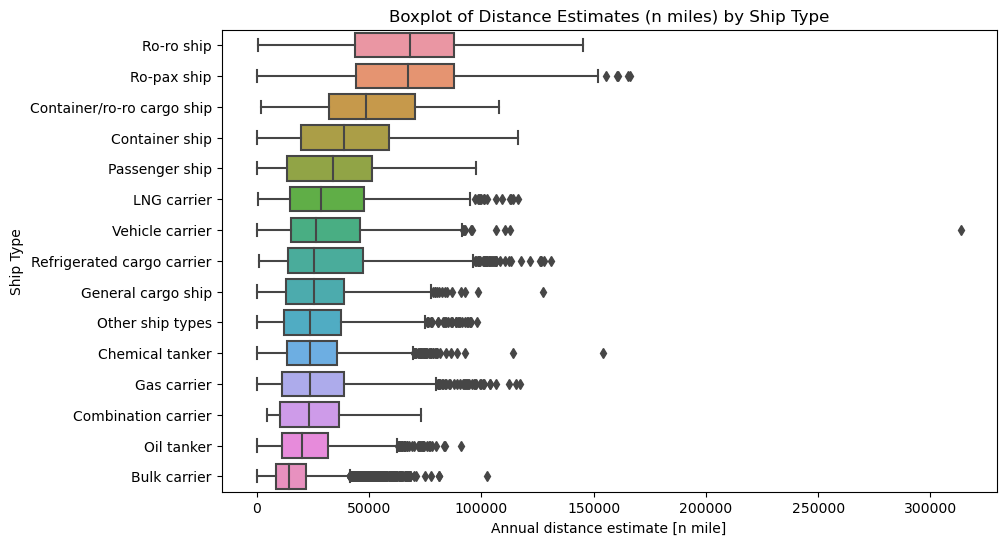

In [40]:
# Create a boxplot of distance estimates by ship type

# Calculate the median of distance for each ship type for ordering purposes
median_order = (
    mrv_df
    .groupby('Ship type')['Annual distance estimate [n mile]']
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(10, 6)) 
sns.boxplot(data=mrv_df, y='Ship type', x='Annual distance estimate [n mile]', order=median_order)

plt.title('Boxplot of Distance Estimates (n miles) by Ship Type')
plt.xlabel('Annual distance estimate [n mile]')
plt.ylabel('Ship Type')
plt.show()

In [42]:
(
    mrv_df
    .sort_values(by='Annual distance estimate [n mile]', ascending=False)
    .head(10)[column_dict['Ship'] + ['Annual distance estimate [n mile]']]
)

,IMO Number,Name,Ship type,Reporting Period,Technical efficiency,Port of Registry,Home Port,Ice Class,Annual distance estimate [n mile]
2803,9285641,MORNING CROWN,Vehicle carrier,2018,NaN,Nassau,NaN,NaN,313736.05
2095,9244116,EUROPEAN HIGHLANDER,Ro-pax ship,2018,0.02,Nassau,NaN,NaN,166176.28
4495,9351505,CRUISE OLYMPIA,Ro-pax ship,2018,19.21,Palermo,NaN,NaN,165372.89
4494,9351490,CRUISE EUROPA,Ro-pax ship,2018,19.21,Palermo,NaN,NaN,160648.24
1348,9198927,CAP FINISTERE,Ro-pax ship,2018,23.05,Morlaix,NaN,NaN,160309.80
28566,9351505,CRUISE OLYMPIA,Ro-pax ship,2020,19.21,Palermo,NaN,NaN,155521.89
14364,9251884,TEAM TOSCA,Chemical tanker,2019,5.19,Monrovia,Monrovia,NaN,154393.94
55487,9498767,MARIE CURIE,Ro-pax ship,2022,19.26,Limassol,NaN,NaN,152105.75
1748,9227417,SUPERFAST XI,Ro-pax ship,2018,24.03,Piraeus,NaN,NaN,149073.38
51873,9319442,FINNSTAR,Ro-pax ship,2022,3.96,Mariehamn,Mariehamn,IA Supper,148529.70


We see that `Bulk carrier`, `Combination carrier` and `Oil tanker` types are among those with smallest median distance estimates and a narrower spread of distance estimates. This might be because transporting dry bulk cargo like coal, grains, or minerals may involve shorter routes between mines, ports, and factories. Similarly, crude oil and petroleum products may be transported between nearby oil fields and refineries. The routes followed by oil tankers may be relatively stable and predictable. Such routes might result in lower annual distances traveled.

`Ro-pax ship` (roll-on/roll-off passenger) and `Ro-ro ship` (roll-on/roll-off cargo) ship types have higher median distance estimates, but also a broader spread of estimates. The spread might be attributed to the wide range of vessel sizes and duties expected from these vessels. The higher medians might be due to the accumulative effect of short but frequent trips in activities like ferry services.

### What is the relationship between ship deadweight and emissions intensity?

DWT - _deadweight tonnage_ refers to how much weight a ship can carry without riding dangerously low in the water, measured in metric tons.

Here, we assume that _intensity_ refers to emissions per unit deadweight carried per nautical mile (g CO₂ / dwt carried · n mile). There are two reported measurements in the dataset which describe this:

- `Technical efficiency`
- `Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]`

We don’t have access to deadweights of ships, but we may be able to derive an estimate of the deadweight of a vessel from other columns. 

According to Table 10 of the [2018-2021 Annual Report from the European Commission](https://climate.ec.europa.eu/system/files/2023-03/swd_2023_54_en.pdf), the "Annual average CO₂ emissions
per transport work (dwt carried)" is reported by "mainly general cargo ships and
other ship types; very few ships of other types."

Emissions intensity may be affected by factors other than just deadweight, such as ship design, fuel type, engine efficiency, and operational practices.

We may want to explore the relationship between technical efficiency and emissions intensity.


Which ship types reported annual average CO₂ emissions per transport work?

In [43]:
# Group by 'Ship type' and calculate summary statistics for emissions per transport work
(
    mrv_df
    .groupby('Ship type')['Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]']
    .describe(percentiles=[.25, .5, .75, .9, .95, .99])
    .sort_values(by='count', ascending=False)
)

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Ship type,,,,,,,,,,,
General cargo ship,5561.0,6.179250e+04,4.399241e+06,0.12,17.3000,23.820,33.1800,51.470,7.627000e+01,3.587960e+02,3.277973e+08
Other ship types,493.0,5.779893e+04,1.144675e+06,0.27,22.7500,36.810,78.7600,258.040,4.519820e+02,5.878909e+04,2.534866e+07
Vehicle carrier,39.0,1.719669e+08,7.611658e+08,0.25,26.3650,85.420,185.4700,3744051.072,7.292514e+08,3.383674e+09,4.517430e+09
Bulk carrier,17.0,1.693412e+01,1.188769e+01,4.50,10.1900,12.060,15.5400,35.590,4.307800e+01,4.447960e+01,4.483000e+01
Container ship,11.0,3.538726e+03,1.145340e+04,10.35,20.3050,31.880,42.6700,608.930,1.933847e+04,3.432209e+04,3.806800e+04
LNG carrier,2.0,1.263500e+01,5.310372e+00,8.88,10.7575,12.635,14.5125,15.639,1.601450e+01,1.631490e+01,1.639000e+01
Chemical tanker,1.0,2.870000e+00,NaN,2.87,2.8700,2.870,2.8700,2.870,2.870000e+00,2.870000e+00,2.870000e+00
Combination carrier,1.0,2.596800e+02,NaN,259.68,259.6800,259.680,259.6800,259.680,2.596800e+02,2.596800e+02,2.596800e+02
Gas carrier,1.0,6.270000e+00,NaN,6.27,6.2700,6.270,6.2700,6.270,6.270000e+00,6.270000e+00,6.270000e+00


We see that this matches the findings of the annual report. Our comparisons using this column will be mainly limited to `General cargo ship` and `Other ship types`.

While the dataset doesn't contain direct figures for each ship's deadweight, we can estimated based on other columns.

If we make the assumption that `Total fuel consumption [m tonnes]` figures are made up entirely of laden voyages, then we can estimate the laden work done by a vessel in a year (in dwt carried · n miles) by using the `Total fuel consumption [m tonnes]` and `Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles]` columns:

$$
\scriptsize
\text{annual deadweight miles} = \frac{\text{total fuel consumption}}{\text{annual average fuel consumption per transport work}}
$$

Dividing this by the annual distance travelled which we derived in our earlier estimate gives us an estimate of the deadweight tonnage of each vessel:

$$
\scriptsize
\text{deadweight tonnage} = \frac{\text{annual deadweight miles}}{\text{annual nautical miles travelled}}
$$

Plugging in our earlier calculation of average distance travelled give us

$$
\scriptsize
\text{deadweight tonnage} = \left( \frac{\text{total fuel consumption}}{\text{annual average fuel consumption per transport work}} \right) \times \left( \frac{\text{average fuel consumption per distance}}{\text{total fuel consumption}} \right)
$$

which cancels down to

$$
\scriptsize
\text{deadweight tonnage} = \frac{\text{average fuel consumption per distance}}{\text{average fuel consumption per transport work}}
$$


In [44]:
# Create a new `DWT estimate [m tonnes]` column
# mrv_df['DWT estimate [m tonnes]'] = mrv_df['Total fuel consumption [m tonnes]'] * 1000000 / (mrv_df['Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles]'] * mrv_df['Annual distance estimate [n mile]'])
mrv_df['DWT estimate [m tonnes]'] = mrv_df['Annual average Fuel consumption per distance [kg / n mile]'] * 1000 / mrv_df['Annual average Fuel consumption per transport work (dwt) [g / dwt carried · n miles]']

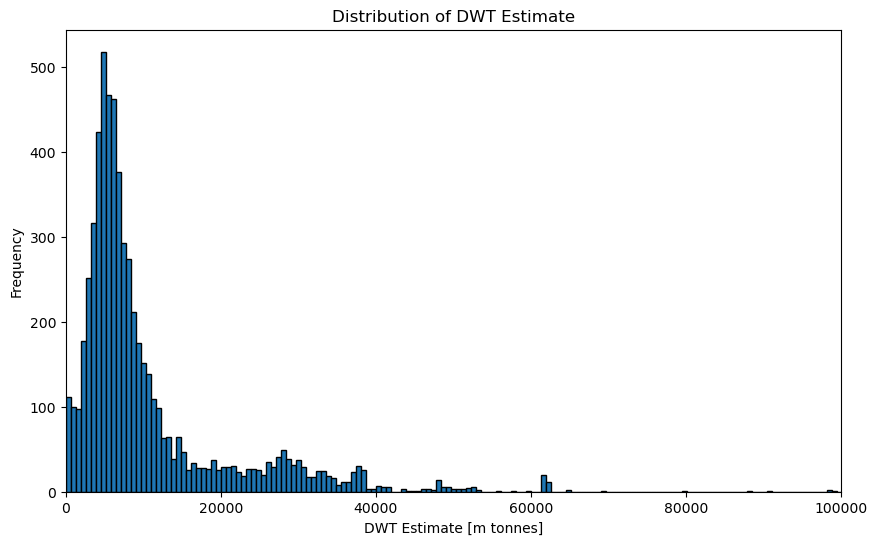

In [45]:
# Create a histogram showing the distribution of DWT Estimate
plt.figure(figsize=(10, 6))
plt.hist(mrv_df['DWT estimate [m tonnes]'], bins=2000, edgecolor='k')  # You can adjust the number of bins as needed

plt.title('Distribution of DWT Estimate')
plt.xlabel('DWT Estimate [m tonnes]')
plt.ylabel('Frequency')

# Set x-axis limits to show values below 200,000
plt.xlim(0, 100000)

plt.show()

In [46]:
# Group by 'Ship type' and calculate summary statistics for deadweight tonnage
(
    mrv_df
    .groupby('Ship type')['DWT estimate [m tonnes]']
    .describe()
    .sort_values(by='count', ascending=False)
)

,count,mean,std,min,25%,50%,75%,max
Ship type,,,,,,,,
General cargo ship,5561.0,11236.329998,21603.910970,0.000721,4688.382193,6728.110599,11192.825112,9.450000e+05
Other ship types,493.0,13426.138618,59769.514017,0.004995,2714.993804,6079.419300,11148.092369,1.291625e+06
Vehicle carrier,39.0,23492.119632,114033.735778,0.000046,1276.403938,2864.380359,10912.762743,7.165000e+05
Bulk carrier,17.0,21667.260570,14287.144286,3411.301860,14643.584521,23626.631854,27355.844156,6.505556e+04
Container ship,11.0,17165.031297,16171.411225,8.035274,8512.520692,14428.290766,22260.956893,5.800906e+04
LNG carrier,2.0,90750.897017,43824.412984,59762.357414,75256.627216,90750.897017,106245.166818,1.217394e+05
Chemical tanker,1.0,79880.434783,NaN,79880.434783,79880.434783,79880.434783,79880.434783,7.988043e+04
Combination carrier,1.0,983.236855,NaN,983.236855,983.236855,983.236855,983.236855,9.832369e+02
Gas carrier,1.0,98876.106195,NaN,98876.106195,98876.106195,98876.106195,98876.106195,9.887611e+04


In [47]:
# Count the values above high percentiles in deadweight tonnage
calculate_percentiles_and_counts(
    mrv_df['DWT estimate [m tonnes]'], 
    [.9, .95, .99, .995]
)

{'90th Percentile': {'Value': 26795.42428819153, 'Count Above': 613},
 '95th Percentile': {'Value': 33218.09523809522, 'Count Above': 307},
 '99th Percentile': {'Value': 61419.8236092266, 'Count Above': 62},
 '100th Percentile': {'Value': 63266.504065039735, 'Count Above': 31}}

What does the relationship between `Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]` and `Technical efficiency` look like?

If the `Technical efficiency` is calculated based on the ships' properties (using the formulas of EEDI and EIV), and `Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]` is calculated based on measurements of actual ship activity, then we would expect there to be at least some correlation between the two.

In [48]:
# Summary statistics for technical efficiency and emissions per tranport work
mrv_df[['Technical efficiency', 'Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]']].describe(percentiles=[.25, .5, .75, .9, .95, .99])

,Technical efficiency,Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]
count,55393.000000,6.129000e+03
mean,10.568114,1.154980e+06
std,13.535391,6.162192e+07
min,0.010000,1.200000e-01
25%,4.420000,1.757000e+01
50%,6.930000,2.435000e+01
75%,13.900000,3.518000e+01
90%,21.070000,5.966800e+01
95%,26.550000,1.110300e+02
99%,41.610000,1.160318e+03


In [49]:
# Count the values above high percentiles in emissions per transport work
calculate_percentiles_and_counts(
    mrv_df['Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]'], 
    [.9, .95, .99, .995]
)

{'90th Percentile': {'Value': 59.66799999999999, 'Count Above': 613},
 '95th Percentile': {'Value': 111.0299999999992, 'Count Above': 307},
 '99th Percentile': {'Value': 1160.3184000000483, 'Count Above': 62},
 '100th Percentile': {'Value': 37786.01599999986, 'Count Above': 31}}

We see a small number of ships with emissions per transport work several orders or magnitude above the median and mean values.

For the purposes of visualising relationships between `Technical efficiency`, `Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]` and `DWT estimate [m tonnes]`, we create a filtered version of the dataset, removing:

- emissions per transport work above the 99 percentile
- technical efficiency above the 99.5 percentile
- DWT Estimate above 70000 m tonnes

In [50]:
# Calculate percentiles for filtering
technical_efficiency_percentile_995 = mrv_df['Technical efficiency'].quantile(0.995)
emissions_transport_work_percentile_99 = mrv_df['Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]'].quantile(0.99)
deadweight_tonnage_limit = 75000

filtered_df_2 = mrv_df[
    (mrv_df['Technical efficiency'] <= technical_efficiency_percentile_995) &
    (mrv_df['Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]'] <= emissions_transport_work_percentile_99) &
    (mrv_df['DWT estimate [m tonnes]'] <= deadweight_tonnage_limit)
]

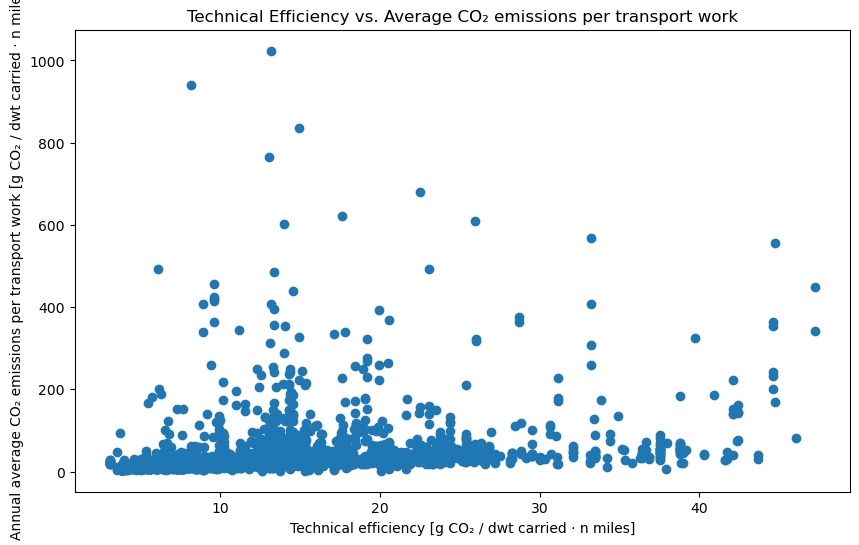

In [51]:
# Create a scatter plot of technical efficiency and emissions per transport work
plt.figure(figsize=(10, 6))

plt.scatter(filtered_df_2['Technical efficiency'], filtered_df_2['Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]'])
plt.title('Technical Efficiency vs. Average CO₂ emissions per transport work')
plt.xlabel('Technical efficiency [g CO₂ / dwt carried · n miles]')
plt.ylabel('Annual average CO₂ emissions per transport work [g CO₂ / dwt carried · n miles]')

plt.show()

What does the relationship between the DWT estimate and annual average CO₂ emissions per transport work look like?

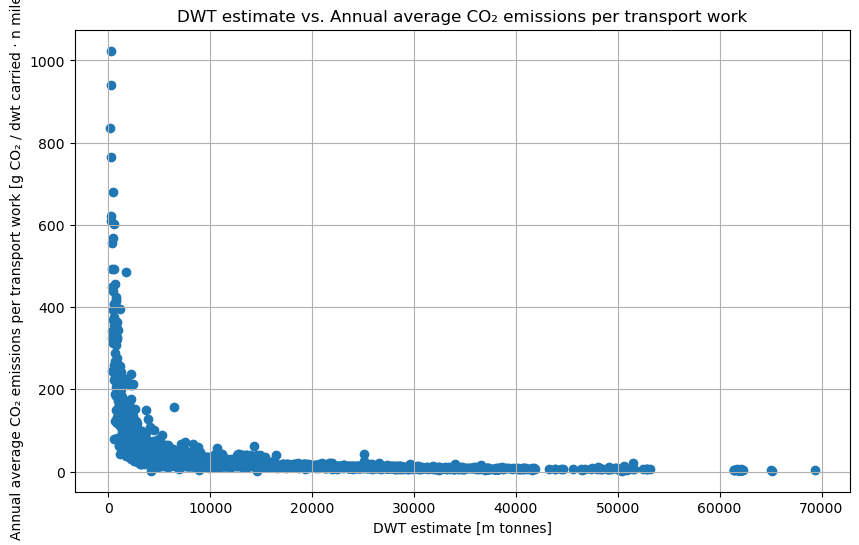

In [53]:
# Create a scatter plot of DWT stimate and annual emissions per transport work
plt.figure(figsize=(10, 6)) 

plt.scatter(filtered_df_2['DWT estimate [m tonnes]'], filtered_df_2['Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]'])
plt.title('DWT estimate vs. Annual average CO₂ emissions per transport work')
plt.xlabel('DWT estimate [m tonnes]')
plt.ylabel('Annual average CO₂ emissions per transport work [g CO₂ / dwt carried · n miles]')

plt.grid(True)
plt.show()

What does the relationship between the DWT estimate and technical efficiency look like?

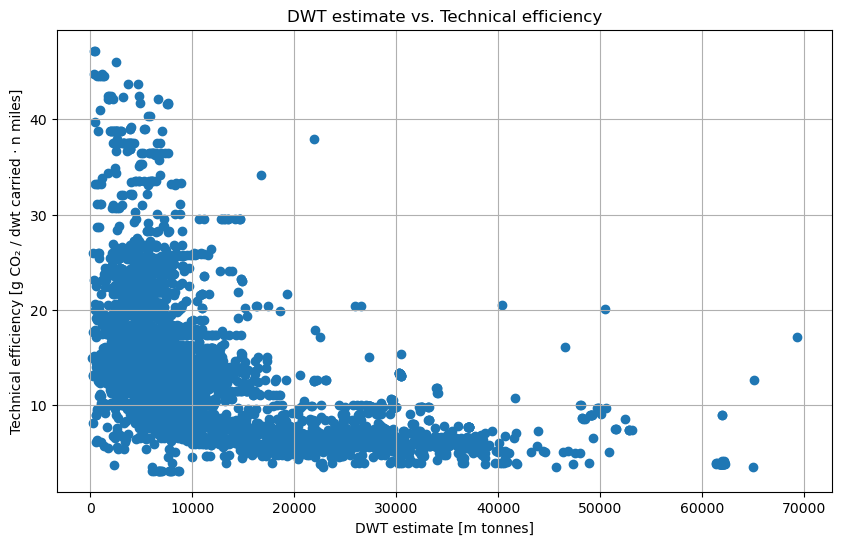

In [54]:
# Create a scatter plot of DWT estimate and technical efficiency
plt.figure(figsize=(10, 6))

plt.scatter(filtered_df_2['DWT estimate [m tonnes]'], filtered_df_2['Technical efficiency'])
plt.title('DWT estimate vs. Technical efficiency')
plt.xlabel('DWT estimate [m tonnes]')
plt.ylabel('Technical efficiency [g CO₂ / dwt carried · n miles]')

plt.grid(True)
plt.show()

What do these relationships look like if we consider only only `General cargo ship` from the latest reporting year (2022)?

In [55]:
general_cargo_ship_2022 = filtered_df_2[
    (filtered_df_2['Ship type'] == 'General cargo ship') 
    & (filtered_df_2['Reporting Period'] == 2022)
]

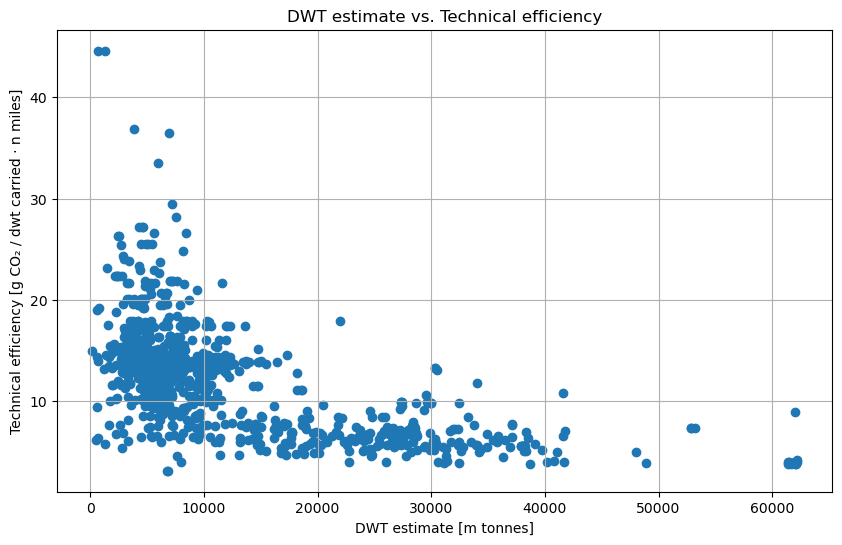

In [56]:
# Create a scatter plot of DWT estimate and technical efficiency for cargo ships in 2022
plt.figure(figsize=(10, 6))

plt.scatter(general_cargo_ship_2022['DWT estimate [m tonnes]'], general_cargo_ship_2022['Technical efficiency'])
plt.title('DWT estimate vs. Technical efficiency')
plt.xlabel('DWT estimate [m tonnes]')
plt.ylabel('Technical efficiency [g CO₂ / dwt carried · n miles]')

plt.grid(True)
plt.show()

It looks like there might be an inverse relationship between the deadweight tonnage and the emissions intensity (as measured by technical efficiency) of a vessel.

Here, we try fitting a linear model to the _inverse_ of technical efficiency and deadweight tonnage:

$$
\scriptsize
\frac{1}{\text{Technical\_efficiency}} = b \cdot \text{Deadweight\_tonnage} + \text{constant}
$$

In [57]:
def invert_target_and_perform_linear_regression(df, predictor_column, target_column):
    '''Takes a dataframe, a predictor column name, a target column name.
    Inverts the target column, performs linear regression, makes predictions.
    Returns the transformed data, the predicted values and the fitted model.'''

    model_data = df[[predictor_column, target_column]].copy().dropna()
    model_data = model_data.rename(columns={predictor_column: 'X', target_column: 'y'})
    model_data['y'] = 1 / model_data['y']

    X = model_data[['X']]
    X = sm.add_constant(X) # Add an intercept term
    y = model_data['y']

    # Create and fit the linear regression model with statsmodels
    model = sm.OLS(y, X).fit()

    # Get the predicted values
    preds = model.predict(X)

    return model_data, preds, model 

In [58]:
def plot_model_data_and_predictions(model_data, preds, predictor_name, target_name, title):
    '''Takes a set of data, a set of predictions, and names for predictor and target
    and a plot title. Plots the data and predictions on the same figure.'''
    # Plot the actual values and predicted values
    plt.scatter(model_data['X'], model_data['y'], label='Actual Values')
    plt.plot(model_data['X'], preds, label='Predicted Values', color='red')
    plt.xlabel(predictor_name)
    plt.ylabel(target_name)
    plt.title(title)
    plt.legend()
    plt.show()

In [59]:
(technical_efficiency_data, 
technical_efficiency_preds, 
technical_efficiency_model) = invert_target_and_perform_linear_regression(
    general_cargo_ship_2022,
    'DWT estimate [m tonnes]',
    'Technical efficiency'
)

In [60]:
technical_efficiency_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     1169.
Date:                Sun, 03 Sep 2023   Prob (F-statistic):          8.72e-167
Time:                        21:38:16   Log-Likelihood:                 1841.5
No. Observations:                 936   AIC:                            -3679.
Df Residuals:                     934   BIC:                            -3669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0612      0.002     38.043      0.000       0.058       0.064
X           3.203e-06   9.37e-08     34.189      0.000    3.02e-06    3.39e-06
==============================================================================
Omnibus:                      332.089   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2148.562
Skew:                           1.468   Prob(JB):                         0.00
Kurtosis:                       9.817   Cond. No.                     2.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

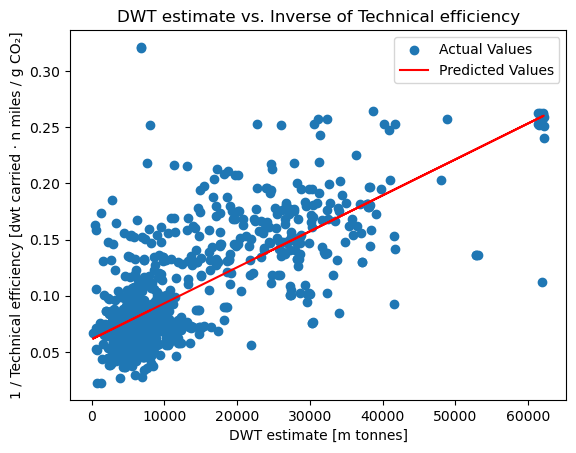

In [61]:
plot_model_data_and_predictions(
    technical_efficiency_data,
    technical_efficiency_preds, 
    'DWT estimate [m tonnes]', 
    '1 / Technical efficiency [dwt carried · n miles / g CO₂]',
    'DWT estimate vs. Inverse of Technical efficiency'
)

This model doesn't appear to describe the relationship very well, with an R2 of about 0.56 (only about 56% of the variance in [the inverse of] technical efficiency is explained by deadweight tonnage.)

What happens when we take the same approach to fitting a linear model for `Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]`?

In [62]:
(emissions_per_transport_work_data, 
emissions_per_transport_work_preds, 
emissions_per_transport_work_model) = invert_target_and_perform_linear_regression(
    general_cargo_ship_2022,
    'DWT estimate [m tonnes]',
    'Annual average CO₂ emissions per transport work (dwt) [g CO₂ / dwt carried · n miles]'
)

In [63]:
emissions_per_transport_work_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     6593.
Date:                Sun, 03 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:38:20   Log-Likelihood:                 2648.2
No. Observations:                 936   AIC:                            -5292.
Df Residuals:                     934   BIC:                            -5283.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0182      0.001     26.828      0.000       0.017       0.020
X           3.213e-06   3.96e-08     81.198      0.000    3.13e-06    3.29e-06
==============================================================================
Omnibus:                       98.646   Durbin-Watson:                   1.418
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              476.239
Skew:                           0.349   Prob(JB):                    3.86e-104
Kurtosis:                       6.424   Cond. No.                     2.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

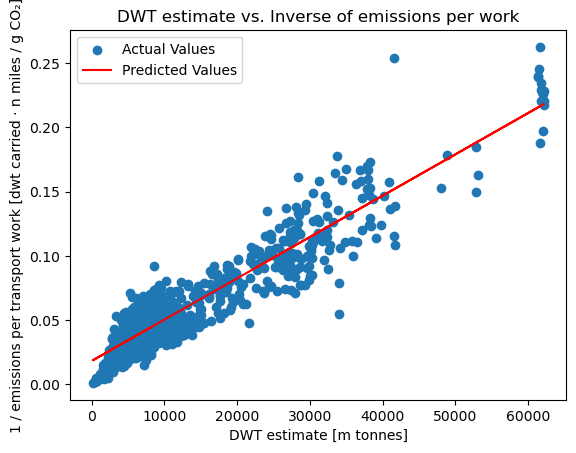

In [64]:
plot_model_data_and_predictions(
    emissions_per_transport_work_data,
    emissions_per_transport_work_preds, 
    'DWT estimate [m tonnes]', 
    '1 / emissions per transport work [dwt carried · n miles / g CO₂]',
    'DWT estimate vs. Inverse of emissions per work'
)

We see that a linear model describes the relationship between deadweight tonnage and (reciprocal of) emissions per transport work quite well, with an R2 of 0.88.

### Areas for further investigation

Given more time, it would be worth looking into the following:

<u>Progress of registered vessels and shipping companies year-on-year</u><br>
Are the carbon emission intensities of individual vessels and company fleets improving over time?

<u>Impact of the UK's withdrawal from the EU</u><br>
In what ways is the UK's withdrawal from the EU reflected in the emissions data?

<u>Data quality analysis</u><br>
How has the reporting of mandatory and voluntary data improved over time? Which shipping companies and verifiers provide the most consistent data?

<u>Ice class and ice navigation</u><br>
What impact does navigating through ice have on a vessel's efficiency and emissions?

<u>Port of registry and home port</u><br>
What effect might local industry practices and regulations have on the efficiencies and emissions profiles of vessels? How does this vary geographically?




